In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import argparse
import pandas as pd
import netCDF4 
import pprint as pprint
    # Import libraries
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import os



In [7]:
def sigmoid(x, L ,x0, k, b):

    y = L / (1 + np.exp(-k*(x-x0)))+b

    return (y)

    
def get_joint_histgram(nx, ny, xmin, xmax, ymin, ymax, x, y):
    """
    :param nx: num of x bins
    :param ny: num of y bins
    :param xmin: lower bound of x bins
    :param xmax: higher bound of x bins
    :param ymin: lower bound of y bins
    :param ymax: higher bound Eof y bins
    :param x: 1D data of x
    :param y: 1D data of y
    :return: jh(ny, nx), x_mid(nx), y_mid(ny)
    """
    jh = np.empty([ny, nx])
    y_median = np.empty([nx])
    x_bins = np.linspace(xmin,xmax, nx+1) #bin_edges
    y_bins = np.linspace(ymin,ymax, ny+1)
    x_mid  = x_bins[:-1] + (x_bins[1] - x_bins[0]) / 2
    y_mid  = y_bins[:-1] + (y_bins[1] - y_bins[0]) / 2
    # print(x_bins)
    # print(y_bins)
    labels = ['Bin {}'.format(i) for i in range(1, nx+1)]
    x_bin = pd.cut(x, x_bins, labels = labels) #x_bin match both x and y
    i = 0
    for bin in labels:
        # print(df.AI[df.x_bins == bin].mean(), df.Nd[df.AI_bins == bin].mean())
        y_median[i] =  y[x_bin == bin].median()
        dict_jh = get_PDF_bin_range(y[x_bin == bin], y_bins)
        jh[:, i] = dict_jh['pdf']
        i += 1
    # fig, ax = plt.subplots()
    # cs = ax.contourf(x_mid, y_mid, jh, cmap='Greys')
    # fig.colorbar(cs, ax=ax)
    return (jh, x_mid, y_mid, y_median)

def get_PDF_bin_range(x, x_bins):
    """
    :param x: 1-D array data
    :param x_bins: bin-edges (length = n_bins+1)
    :return: dict: 1) 'x': mid_value of x for each bin
                   2) 'pdf': PDF for each bin (%)
    """
    dict_PDF        ={}
    hist, bin_edges = np.histogram(x, bins=x_bins)
    dict_PDF['x']   = bin_edges[0:len(x_bins)-1]+(bin_edges[1]-bin_edges[0])/2 #mid value
    dict_PDF['pdf'] = hist/sum(hist)*100
    # fig, ax = plt.subplots()
    # ax.plot(dict_PDF['x'], dict_PDF['pdf'], color='black', linewidth=3)
    return (dict_PDF)    


def get_values_joint_hist(xedges, yedges):
    """
    :param nx: num of x bins  20
    :param ny: num of y bins  20 
    :param xmin: lower bound of x bins 
    :param xmax: higher bound of x bins
    :param ymin: lower bound of y bins
    :param ymax: higher bound Eof y bins
    :param x: 1D data of x
    :param y: 1D data of y
    :return: jh(ny, nx), x_mid(nx), y_mid(ny)
    """
    
    xedges_mid  = xedges[:-1] + (xedges[1] - xedges[0]) / 2
    yedges_mid  = yedges[:-1] + (yedges[1] - yedges[0]) / 2
    print("========print xedges_mid", xedges_mid)
    print("========print yedges_mid", yedges_mid)

    return (xedges_mid, yedges_mid)



Nd_max min, max <xarray.DataArray 'Nd_max' ()>
array(0.) <xarray.DataArray 'Nd_max' ()>
array(3446.75920724)
lwp min, max <xarray.DataArray 'lwp' ()>
array(0.) <xarray.DataArray 'lwp' ()>
array(4600.84033203)
+++++print contourf x,y,jh (30,) (35,) (35, 30)


/tmp/ipykernel_3893217/1664219911.py:24: RuntimeWarning: divide by zero encountered in log
  df = pd.DataFrame({'LWP': np.log(np.float_(y)),'Nd': np.log(np.float_(x))})


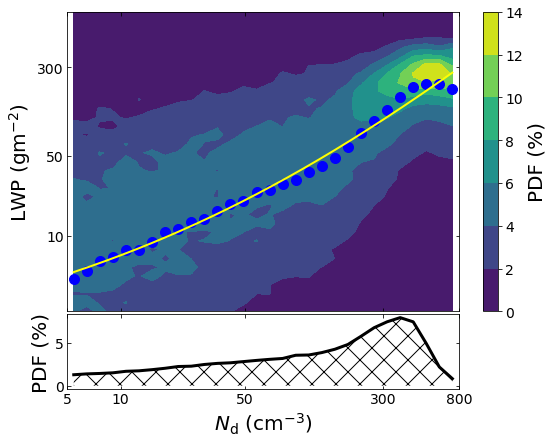

In [9]:

# path_output=$HOME/Documents/phd/output 

path_ICON = "/work/bb1036/b381362/dataset/data_rttov_T12_dropupbottom_Reff.nc" 
path_output ='/work/b/b381362/output/'


ds=xr.open_dataset(path_ICON)
file_name= os.path.splitext(os.path.basename(path_ICON))[0][:-5] #data_rttov_T12_dropupbottom_Reff.nc delete _Reff


print("Nd_max min, max", ds.Nd_max.min(), np.max(ds.Nd_max))
print("lwp min, max", ds.lwp.min(), np.max(ds.lwp))

# Creating dataset
x = ds.Nd_max.values.flatten()
y = ds.lwp.values.flatten()


x = np.ma.masked_array(x,  x == 0) 
y = np.ma.masked_array(y,  y == 0) 


### ***************************************************************
df = pd.DataFrame({'LWP': np.log(np.float_(y)),'Nd': np.log(np.float_(x))})

# print(df.AI,df.Nd)
nx = 30
ny = 35



jh, x_mid, y_mid, y_median = get_joint_histgram(nx,ny,np.log(5), np.log(800), np.log(2), np.log(1000),df.Nd,df.LWP)

p0 = [max(y_median), np.median(x_mid), np.log(1000), min(y_median)]  # this is an mandatory initial guess
popt, pcov = curve_fit(sigmoid, x_mid, y_median, p0, method='dogbox')
x0 = np.linspace(x_mid.min(), x_mid.max(), 800)
y0 = sigmoid(x0, *popt)


# definitions for the axes
left, width = 0.12, 0.85
bottom, height = 0.3, 0.52
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom - 0.13 - spacing, width-0.17, 0.13]


parameters = {'axes.labelsize': 20,
              'axes.titlesize': 35,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              }
plt.rcParams.update(parameters)

# start with a square Figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)

# no labels
ax.tick_params(axis="x", labelbottom=False)
ax.tick_params(direction='in', top=True, right=True)
ax_histx.tick_params(direction='in', top=True, right=True)
ax.set_ylabel('LWP (gm$\mathregular{^{-2}}$)')

ax.set_yticks(np.log(np.array([2, 10, 50, 300, 1000])))
ax.set_yticklabels(['2', '10', '50', '300', '1000'])

ax_histx.set_xlabel('$\it{N}$$\mathregular{_d}$ (cm$\mathregular{^{-3}}$)')
ax_histx.set_ylabel('PDF (%)')


print("+++++print contourf x,y,jh", np.shape(x_mid), np.shape(y_mid), np.shape(jh))
cs = ax.contourf(x_mid, y_mid, jh, cmap='viridis') #Greys

fig.colorbar(cs, ax=ax, label='PDF (%)')


ax.scatter(x_mid, y_median, color='blue', marker='o', s=100)
ax.plot(x0,y0,color='yellow', label='sigmoid fit', lw=2)



#PDF plot
dict_PDF = get_PDF_bin_range(df['Nd'], np.linspace(np.log(5), np.log(800), nx+1))
ax_histx.plot(dict_PDF['x'], dict_PDF['pdf'], color='black', linewidth=3)
ax_histx.fill_between(dict_PDF['x'], 0, dict_PDF['pdf'], facecolor='w', alpha=0.7, hatch = 'x')

plt.xticks(np.log(np.array([5, 10, 50, 300,800])),np.array([5, 10, 50, 300,800]).astype(str))

figure_name = '{}_relation_LWP-Nd-density-H.png'.format(os.sep.join([path_output,file_name]))    

# fig.savefig(figure_name) 
plt.show()





In [32]:
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))
def linreg_by_bin(df_2_vars, nbins = 10, ax = None, label = None, equal_size = True, **args):
    x = df_2_vars.iloc[:,0].values
    if equal_size:
        x_bins = equalObs(x, nbins) # bins of ~ equal size
    else:
        x_bins = np.linspace(np.min(x), np.max(x), nbins)
    results = []
    for i in range(len(x_bins)-1):
        df_bin = df_2_vars.loc[((x < x_bins[i+1])&
                                  (x > x_bins[i])),:]
        if len(df_bin)>10:
            x_middle = x_bins[i]+(x_bins[i+1] - x_bins[i])/2
            y_median = np.median(df_bin.iloc[:,1].values)
            if equal_size:
                x_middle = np.median(df_bin.iloc[:,0].values)
            y_10pct = np.percentile(df_bin.iloc[:,1].values, 25)
            y_90pct = np.percentile(df_bin.iloc[:,1].values, 75)
        else: x_middle, y_median, y_10pct, y_90pct= [np.nan, np.nan, np.nan, np.nan]
        results.append([x_middle, y_median, y_10pct, y_90pct])
    results = pd.DataFrame(data=results,columns = ['x_middle', 'y_median', 'y_10pct', 'y_90pct'])
    if ax is None:
        f,ax = plt.subplots()
    
    ax.fill_between(x=results.x_middle, y1=results.y_10pct, y2=results.y_90pct, color= 'lightgrey', alpha = 0.5)
    sns.regplot(x=results.x_middle, y = results.y_median, marker = 'o', ax=ax, ci=0, label=label)
    #reg_binned = LinearRegression().fit(results.dropna().x_middle.values.reshape(-1,1), results.dropna().y_median.values.reshape(-1,1))
    #ax.text(0.2, 0.8, f"coeff = {np.round(reg_binned.coef_[0][0],3)}", transform=ax.transAxes)
    ax.set_xlabel(df_2_vars.columns[0])
    ax.set_ylabel(df_2_vars.columns[1])
    if label is not None:
        plt.legend()
    return results

In [29]:
df

,LWP,Nd
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,2.288803,2.504936
4,3.063811,3.100091
...,...,...
369887,2.184849,4.125982
369888,-1.582861,2.146227
369889,2.475964,4.509260
369890,4.410529,4.600859


/tmp/ipykernel_3893217/4211164028.py:3: RuntimeWarning: divide by zero encountered in log
  df = pd.DataFrame({'Nd': np.log(np.float_(x)),'LWP': np.log(np.float_(y))})


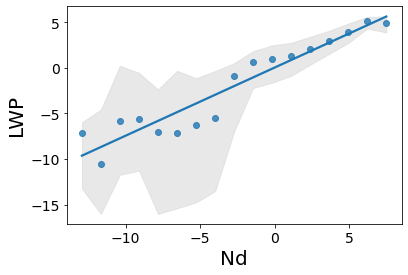

In [36]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
df = pd.DataFrame({'Nd': np.log(np.float_(x)),'LWP': np.log(np.float_(y))})

df_2_vars = df.dropna()

results = linreg_by_bin(df_2_vars, nbins = 50, equal_size=False)
